# Tutorial

In [1]:
import pickle
import torch
import torch.optim as optim
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import data_loader
import models


## Loading data

Each event sequence is represented as a list of dictionaries. The dictionary represent when and what event has happens. The following gives the first three events in the first training sequene.


In [2]:
with open('data/test_ev50_big.pkl', 'rb') as handle:
    train_data = pickle.load(handle)


train_data['train'] += train_data['dev']
train_data['train'] += (train_data['test'])

train_data['train'][0][:3]

[{'idx_event': 1,
  'type_event': 9,
  'time_since_start': 0.01705424730918858,
  'time_since_last_event': 0.01705424730918858,
  'time_since_last_same_event': 0.01705424730918858},
 {'idx_event': 2,
  'type_event': 40,
  'time_since_start': 0.01773276790150446,
  'time_since_last_event': 0.0006785205923158823,
  'time_since_last_same_event': 0.01773276790150446},
 {'idx_event': 3,
  'type_event': 10,
  'time_since_start': 0.018065941823793098,
  'time_since_last_event': 0.00033317392228863693,
  'time_since_last_same_event': 0.018065941823793098}]

The `process_seq` helper function converts the sequence from a list to several numpy arraies, encoding information such as event time and event type.

In [3]:
max_len = 20
n_event_type = dim_process = 50
n_sample = 10000
context_dim = 1

train_input = data_loader.process_seq(train_data, list(range(n_sample)), max_len=max_len, n_event_type=n_event_type,
                                      tag_batch='train', dtype=np.float32)


The simulation data set does not contain static feature, so we create dummies (a matrix with all ones) as the static feature.

In [4]:
batch_input_np = list(train_input)
df_patient_static_mat = np.ones((1, n_sample)).astype('float32')
batch_input_np.append(df_patient_static_mat)


gap = batch_input_np[0][:-1, :] - batch_input_np[0][1:, :]
gap_mean = np.mean(gap)
gap_std = np.std(gap)



Loading the ground-truth model that generated the data.

In [5]:

with open('data/model_test_ev50_big.pkl', 'rb') as handle:
    true_model = pickle.load(handle)


true_alpha = true_model['alpha'] / true_model['delta']
true_lambda = true_model['delta']


## Training model

First we defined the model the the optimizer in the standard way. We compare the DDP with the Hawkes process.

In [6]:
alpha_init = np.float32(
    np.log(
        np.random.uniform(
            low=0.5, high=1.5,
            size=(dim_process, dim_process)
        )
    )
)

lambda_init = np.float32(
    np.log(
        np.random.uniform(
            low=10.0, high=20.0,
            size=(dim_process, dim_process)
        )
    )
)

ddp_model = models.DDP(
    n_event_type=n_event_type, 
    n_context_dim=context_dim, 
    first_occurrence_only=False, 
    embedding_size=50, 
    rnn_hidden_size=50,
    alpha_mat_np=alpha_init,
    lambda_mat_np=lambda_init,
    gap_mean=gap_mean, 
    gap_scale=gap_std
)
opt_ddp = optim.SGD(ddp_model.parameters(), lr=0.001, momentum=0.9)

c_hawkes_model = models.CHawkes(n_event_type=n_event_type, n_context_dim=context_dim,
                                first_occurrence_only=False, alpha_mat_np=alpha_init, lambda_mat_np=lambda_init)
opt_c_hawkes = optim.SGD(c_hawkes_model.parameters(), lr = 0.001, momentum=0.9)

with torch.no_grad():
    test_batch = data_loader.get_whole_batch(batch_input_np)



Setting up training parameters.

In [7]:

with torch.no_grad():
    test_batch = data_loader.get_whole_batch(batch_input_np)


mat_dist_ddp = list()
mat_dist_hawkes = list()

rnn_sd = list()

batch_size = 100
training_itr = 1000
report_step = 1

current_best = 10000

We start the training iteration.

In [8]:

for i in range(training_itr):
    
    if i % report_step == 0:
        with torch.no_grad():
            test_batch = data_loader.get_whole_batch(batch_input_np)

            ddp_model.set_input(*test_batch)

            weights = ddp_model.graph_weights_seq.numpy()
            rnn_sd.append(np.std(weights))

            avg_weight_list = list()

            a = test_batch[4].numpy()
            b = test_batch[2].numpy()

            for j in range(n_event_type):
                ind = np.logical_not(np.logical_and(a == 1, b == j))
                weights_cp = np.copy(weights)
                weights_cp[ind] = np.nan
                avg_weight_list.append(np.nanmean(weights_cp)) 

            avg_weight = np.array(avg_weight_list)
            mat_dist_ddp.append(
                np.sum(np.abs(torch.exp(ddp_model.alpha_mat).numpy() * avg_weight - true_alpha)))
            mat_dist_hawkes.append(np.sum(np.abs(torch.exp(c_hawkes_model.alpha_mat).numpy() - true_alpha)))

    mini_batch = data_loader.get_mini_batch(batch_size, batch_input_np)
    
    ddp_model.set_input(*mini_batch)
    log_lik = ddp_model() * (-1.0)
    models.cross_ent_one_step(log_lik, opt_ddp)

    c_hawkes_model.set_input(*mini_batch)
    log_lik2 = c_hawkes_model() * (-1.0)
    models.cross_ent_one_step(log_lik2, opt_c_hawkes)
    

Visualizing the training performance as follows:

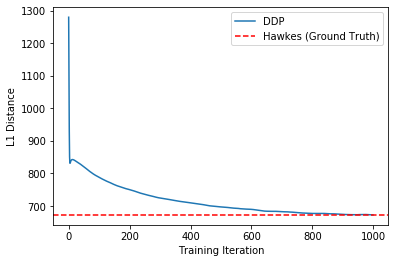

In [9]:
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
line = ax.plot(np.array(mat_dist_ddp), label='DDP')
ax.axhline(y=min(mat_dist_hawkes), color='r', linestyle='--', label='Hawkes (Ground Truth)')
plt.xlabel('Training Iteration')
plt.ylabel('L1 Distance')
plt.legend()